# Setting

In [1]:
!apt-get update -qq
!apt-get install -qq fonts-nanum

# matplotlib에 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정
font_path = 'C:/Windows/Fonts/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
# !pip install yfinance
# !pip install statsmodels


# import

In [3]:
import os
import yfinance as yf
import pandas as pd

import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

import itertools

import time

import backtrader as bt
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
from multiprocessing import Pool


# Read S&P 500

## s&p500크롤링

In [8]:

csv_file_path = "./csv/snp500.csv"

#각 종목의 시가총액 가져오는 함수 !이젠 필요없음
def get_market_cap(ticker):
    stock = yf.Ticker(ticker)
    try:
        market_cap = stock.info['marketCap']  # 시가총액
    except KeyError:
        market_cap = None
    return market_cap

# S&P 500 종목 리스트 가져오기
# pd.read_html() 함수는 웹페이지에 있는 HTML 테이블을 DataFrame으로 변환
def load_sp500_data():
    if os.path.exists(csv_file_path):
        print("CSV파일에서 s&p500 데이터를 로드합니다.")
        sp500 = pd.read_csv(csv_file_path)
    else:
         print("웹에서 S&P 500 데이터를 가져옵니다.")
         sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
         sp500['Market Cap'] = sp500['Symbol'].apply(get_market_cap) #시가총액 주가
         sp500.to_csv(csv_file_path, index=False) #데이터를 csv로 저장

    return sp500


sp500 = load_sp500_data()


# 시가총액 정보를 추가 위해 티커(symbol) 리스트를 추출
tickers = sp500['Symbol'].tolist()


# 섹터별 시가총액 상위 4개 종목 선택 !이젠 필요 없음
top_by_sector = sp500.groupby('GICS Sector').apply(lambda x: x.nlargest(4, 'Market Cap'))

# 산업군 전체 종목 선택
all_per_industry = sp500.groupby('GICS Sub-Industry').apply(lambda x: x)


# 섹터별로 시가총액 상위 종목들 출력
#print(top_by_sector[['Symbol', 'Security', 'Market Cap']])

# 산업군 별 시가총액 상위 종목 출력
#print(all_per_industry[['Symbol', 'Security', 'Market Cap']])

# 파일로 저장
sp500.to_csv("./csv/snp500.csv", index=False)  # 이미 데이터가 있으면 덮어쓰지 않음


CSV파일에서 s&p500 데이터를 로드합니다.


C:\Users\eujin\AppData\Local\Temp\ipykernel_3568\4018800259.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_by_sector = sp500.groupby('GICS Sector').apply(lambda x: x.nlargest(4, 'Market Cap'))
C:\Users\eujin\AppData\Local\Temp\ipykernel_3568\4018800259.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_per_industry = sp500.groupby('GICS Sub-Industry').apply(lambda x: x)


## 섹터, 산업군 별 데이터

In [9]:

# 각 섹터의 종목 데이터를 가져오기 위한 함수
def get_data(tickers, start_date="2023-01-01", end_date="2023-12-31"):
    # 데이터 수집 (Adjusted Close 가격을 가져옴)
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data


#기본 분석 기간
default_start_date = "2023-01-01"
default_end_date = "2023-12-31"

#데이터 예시
it_sector_tickers = top_by_sector.loc['Information Technology']['Symbol'].tolist()

it_sector_data = get_data(it_sector_tickers)


it_industry_tickers = all_per_industry.loc['Advertising']['Symbol'].tolist()

it_industry_data = get_data(it_industry_tickers)


# 종목 간 상관관계
sector_correlation_matrix = it_sector_data.corr()
print("섹터 상관관계 매트릭스:")
print(sector_correlation_matrix)


industry_correlation_matrix = it_industry_data.corr()
print("산업군 상관관계 매트릭스:")
print(industry_correlation_matrix)


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed

섹터 상관관계 매트릭스:
Ticker      AAPL      AVGO      MSFT      NVDA
Ticker                                        
AAPL    1.000000  0.875553  0.948934  0.921846
AVGO    0.875553  1.000000  0.917176  0.943091
MSFT    0.948934  0.917176  1.000000  0.936636
NVDA    0.921846  0.943091  0.936636  1.000000
산업군 상관관계 매트릭스:
Ticker       IPG       OMC
Ticker                    
IPG     1.000000  0.937923
OMC     0.937923  1.000000


## 볼린저 밴드 그래프 함수, 안정적 페어 고르기 함수

In [ ]:
# -------- 코드 셀 2: 볼린저 밴드 그래프 및 안정적인 페어 선택 --------

def calculate_p_value(data, ticker1, ticker2):
    # 독립 변수와 종속 변수에 대해 NaN 및 inf 값 제거
    x = data[ticker1].replace([np.inf, -np.inf], np.nan).dropna()
    y = data[ticker2].replace([np.inf, -np.inf], np.nan).dropna()

    # 데이터의 길이를 맞추기 위해 공통 인덱스 사용
    common_index = x.index.intersection(y.index)
    x = x.loc[common_index]
    y = y.loc[common_index]

    # 데이터 길이가 충분한지 확인
    if len(x) == 0 or len(y) == 0:
        print(f"Insufficient data for {ticker1} and {ticker2}. Skipping this pair.")
        return None, None

    # 상수항 추가 후 OLS 회귀 분석
    x = sm.add_constant(x)
    ols_model = sm.OLS(y, x).fit()
    residuals = ols_model.resid

    # 잔차에 대해 ADF 테스트 수행
    adf_result = adfuller(residuals)
    return adf_result[1], residuals  # p-value와 잔차 반환

def plot_bollinger_bands(residuals, ticker1, ticker2):
    # 30일 이동 평균과 표준편차 계산
    moving_avg = residuals.rolling(window=30).mean()
    moving_std = residuals.rolling(window=30).std()

    # 볼린저 밴드 계산
    upper_band = moving_avg + (2 * moving_std)
    lower_band = moving_avg - (2 * moving_std)
    
    # 매매 규칙
    # 잔차가 상단을 넘으면 매도, 하단을 넘으면 매수
    #entry_signals = (residuals > upper_band) | (residuals < lower_band)
    #exit_signals = residuals.rolling(window=60).mean().shift(1)  # 이동평균선이 교차할 때 청산

    # 볼린저 밴드와 잔차 시각화
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='잔차', color='blue')
    plt.plot(moving_avg, label='30일 이동 평균', color='orange')
    plt.fill_between(residuals.index, lower_band, upper_band, color='gray', alpha=0.3, label='볼린저 밴드')
    plt.legend()
    plt.title(f'잔차와 볼린저 밴드 ({ticker1} vs {ticker2})')
    plt.show()


# 안정적인 페어 선택 함수
def select_stable_pair(sp500, start_date, end_date, adf_threshold=0.05):
    industry_groups = sp500.groupby("GICS Sub-Industry")

    stable_pairs = []

    for industry, group in industry_groups:
        tickers = group['Symbol'].tolist()
        if len(tickers) < 2:
            continue  # 페어 분석을 위한 최소 두 개 이상의 종목이 필요

        data = get_data(tickers, start_date=start_date, end_date=end_date)
        pairs = list(itertools.combinations(tickers, 2))

        best_pair = None
        lowest_std = float('inf')

        for pair in pairs:
            # TODO: 티커 2개를 받아서 p-value를 반환하는 함수로 분리하기
            x_ticker, y_ticker = pair
            p_value, residuals = calculate_p_value(data, x_ticker, y_ticker)

            # 잔차가 평균 회귀적 성향을 보이는지 ADF 테스트로 확인
            if p_value is not None:
                # 잔차의 표준편차 계산
                residual_std = residuals.std()
                #print(f"Pair: {x_ticker} and {y_ticker} - 잔차 표준편차: {residual_std}, ADF p-value: {p_value}")

                if residual_std < lowest_std and p_value < adf_threshold:
                    best_pair = pair
                    lowest_std = residual_std
                    best_p_value = p_value
                    #stable_pair = pair
                    #lowest_std = residual_std
        if best_pair:
                stable_pairs.append({
                    "Sector": group["GICS Sector"].iloc[0],
                    "Industry Group": industry,
                    "Ticker 1": best_pair[0],
                    "Ticker 2": best_pair[1],
                    "P-Value": best_p_value,
                    "Residual Std": lowest_std
                })
    return pd.DataFrame(stable_pairs)



## 페어 테이블

In [11]:
stable_pairs_df = select_stable_pair(sp500, start_date="2023-01-01", end_date="2023-12-31")
print(stable_pairs_df)

# 안정적인 페어 테이블을 CSV 파일로 저장
stable_pairs_df.to_csv("./csv/stable_pairs.csv", index=False)


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%**

Insufficient data for BF.B and STZ. Skipping this pair.


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  4 of 4 completed

1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1703998800")')


Insufficient data for AMTM and CTAS. Skipping this pair.
Insufficient data for AMTM and CPRT. Skipping this pair.
Insufficient data for AMTM and LDOS. Skipping this pair.


[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%****

Insufficient data for AMCR and SW. Skipping this pair.
Insufficient data for AVY and SW. Skipping this pair.
Insufficient data for IP and SW. Skipping this pair.
Insufficient data for PKG and SW. Skipping this pair.


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%******

                    Sector                                Industry Group  \
0              Industrials                           Aerospace & Defense   
1              Industrials                       Air Freight & Logistics   
2   Information Technology                          Application Software   
3               Financials              Asset Management & Custody Banks   
4              Health Care                                 Biotechnology   
5   Communication Services                                  Broadcasting   
6   Consumer Discretionary                              Broadline Retail   
7   Consumer Discretionary                              Casinos & Gaming   
8   Information Technology                      Communications Equipment   
9               Financials                              Consumer Finance   
10        Consumer Staples           Consumer Staples Merchandise Retail   
11  Consumer Discretionary                                  Distributors   
12          

## 테이블 페어간 볼린저 밴드

[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

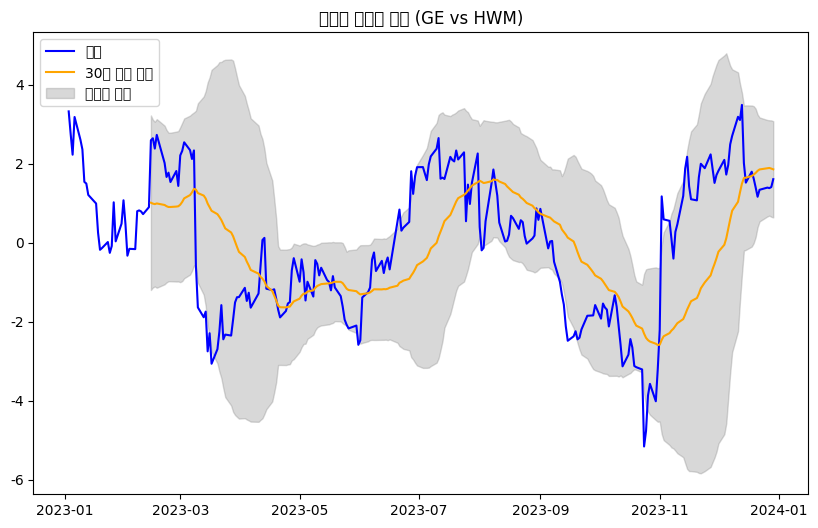

Bollinger Band graph saved for GE and HWM at ./bollinger_band\GE_HWM_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

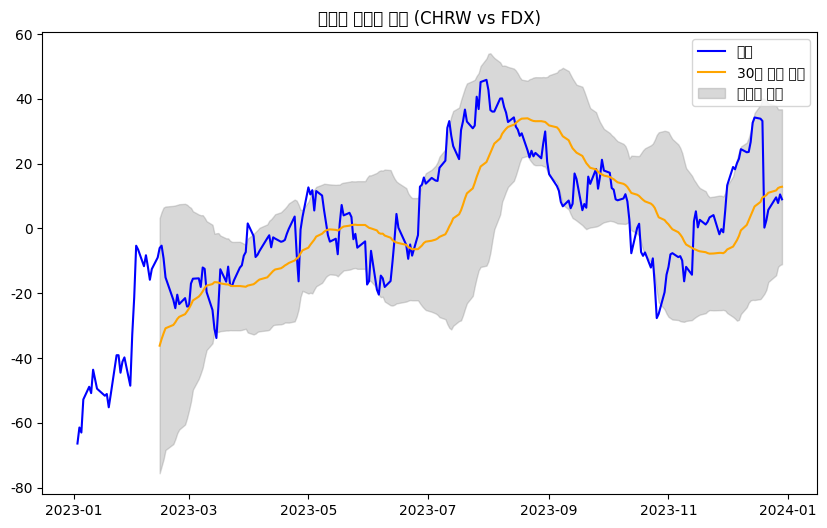

Bollinger Band graph saved for CHRW and FDX at ./bollinger_band\CHRW_FDX_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

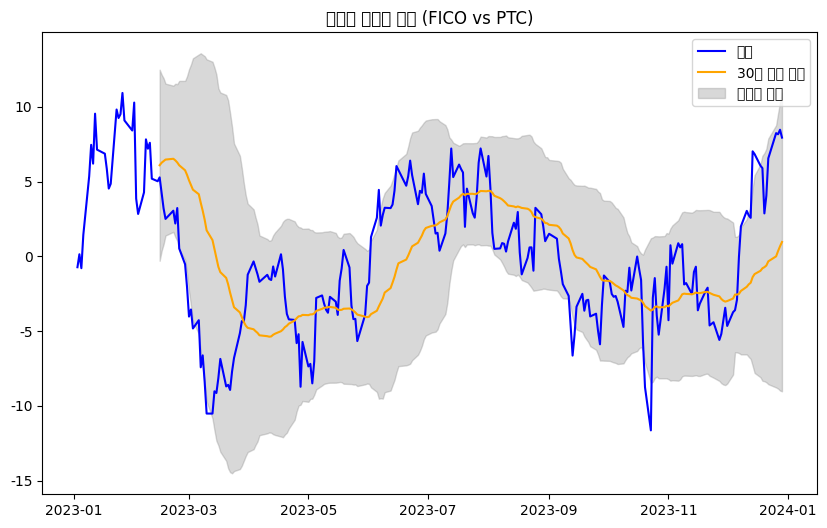

Bollinger Band graph saved for FICO and PTC at ./bollinger_band\FICO_PTC_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

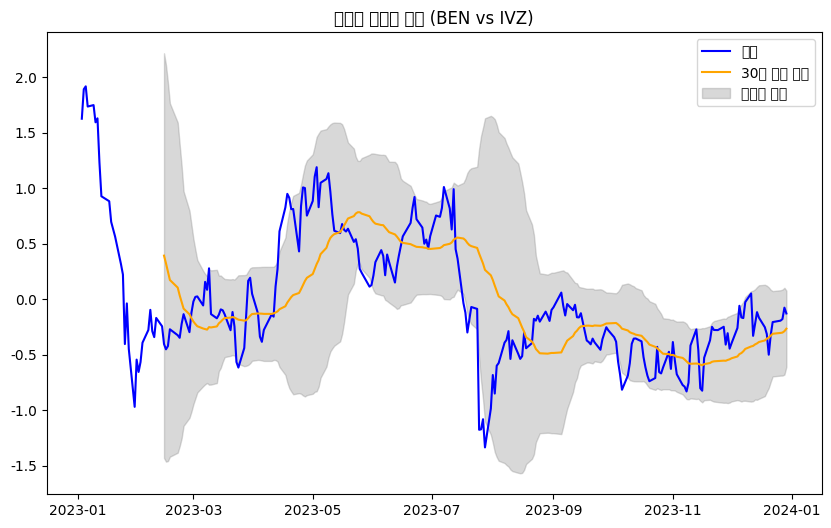

Bollinger Band graph saved for BEN and IVZ at ./bollinger_band\BEN_IVZ_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

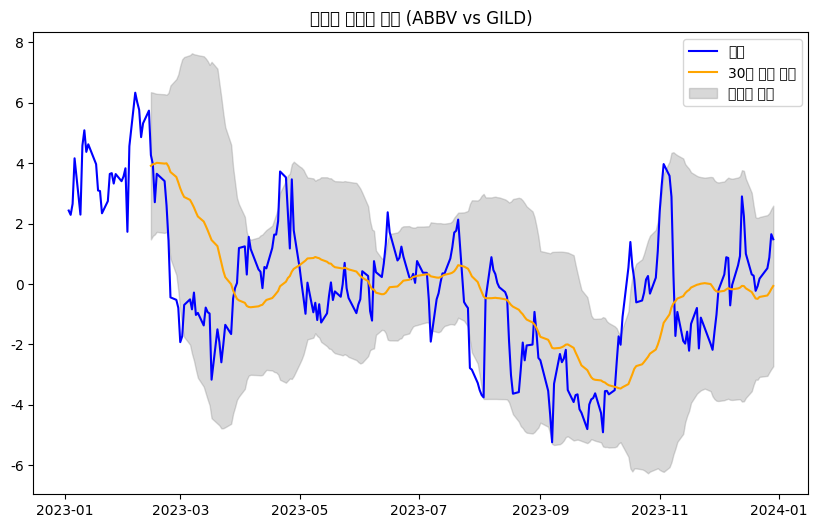

Bollinger Band graph saved for ABBV and GILD at ./bollinger_band\ABBV_GILD_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

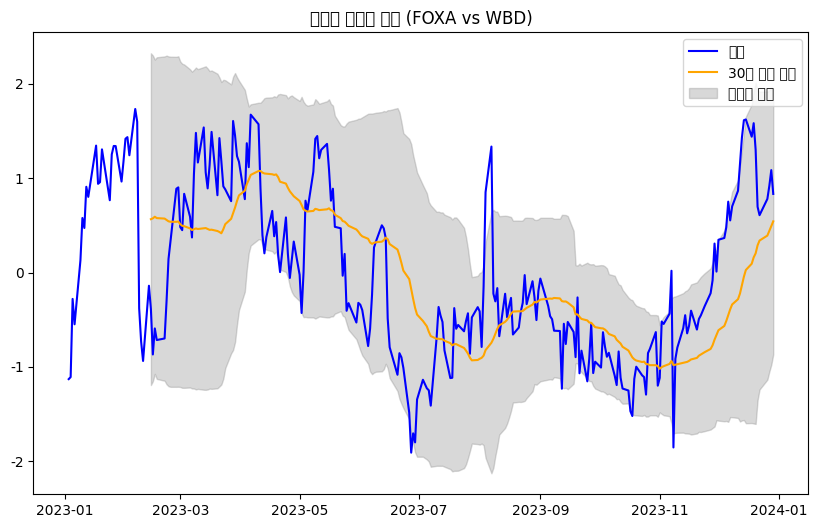

Bollinger Band graph saved for FOXA and WBD at ./bollinger_band\FOXA_WBD_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

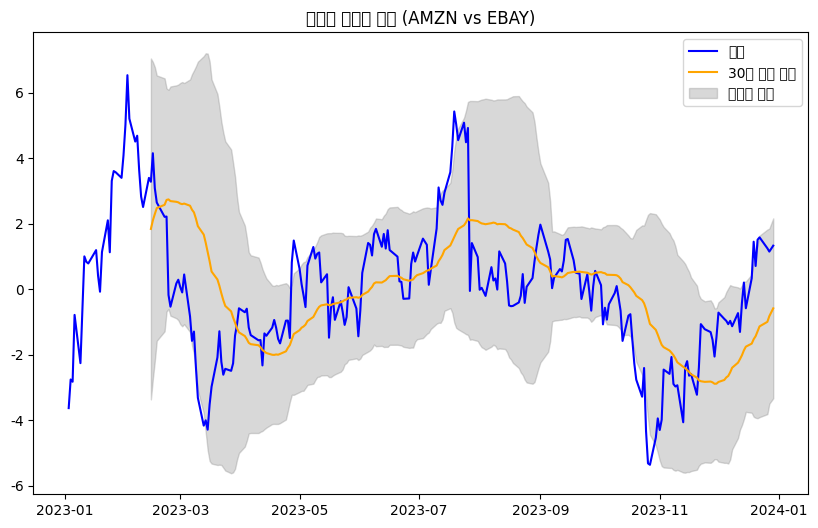

Bollinger Band graph saved for AMZN and EBAY at ./bollinger_band\AMZN_EBAY_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

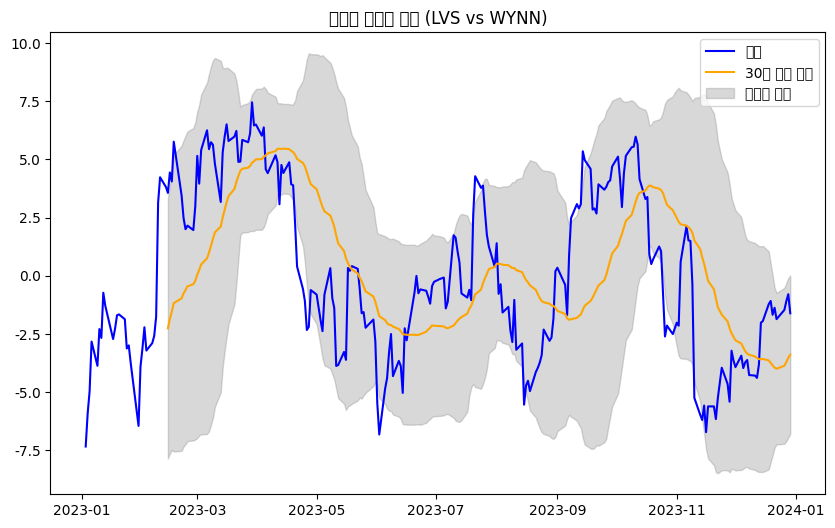

Bollinger Band graph saved for LVS and WYNN at ./bollinger_band\LVS_WYNN_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

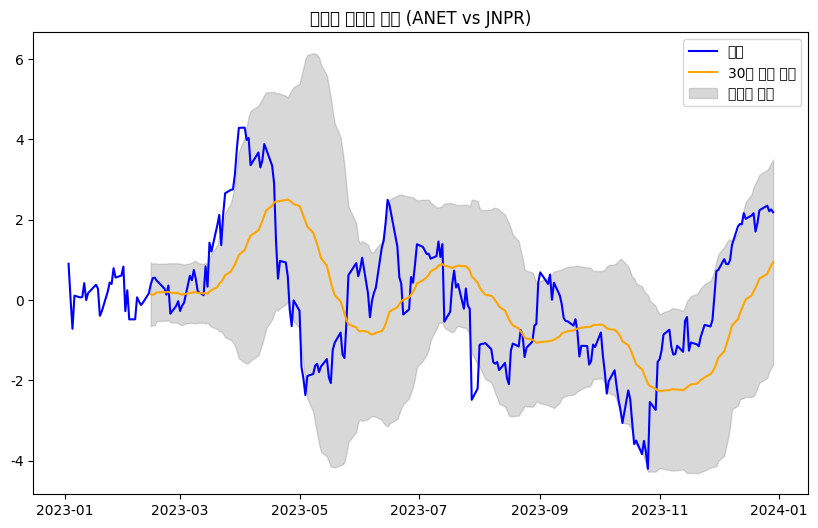

Bollinger Band graph saved for ANET and JNPR at ./bollinger_band\ANET_JNPR_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

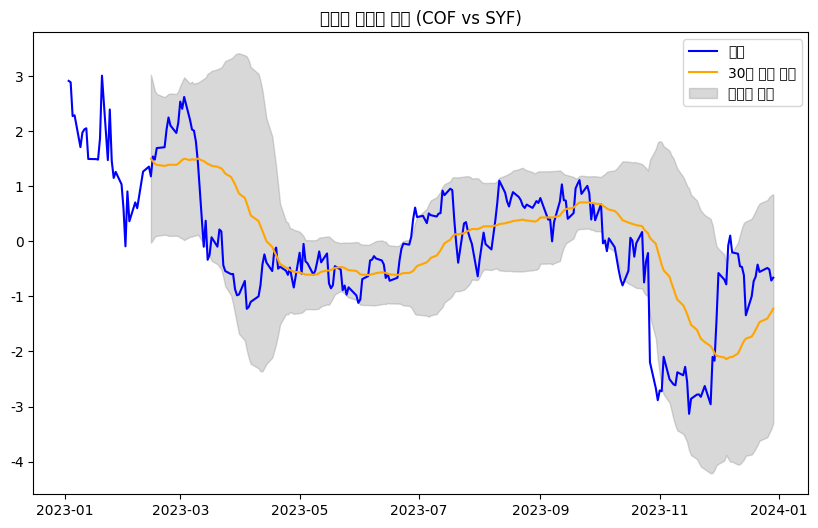

Bollinger Band graph saved for COF and SYF at ./bollinger_band\COF_SYF_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

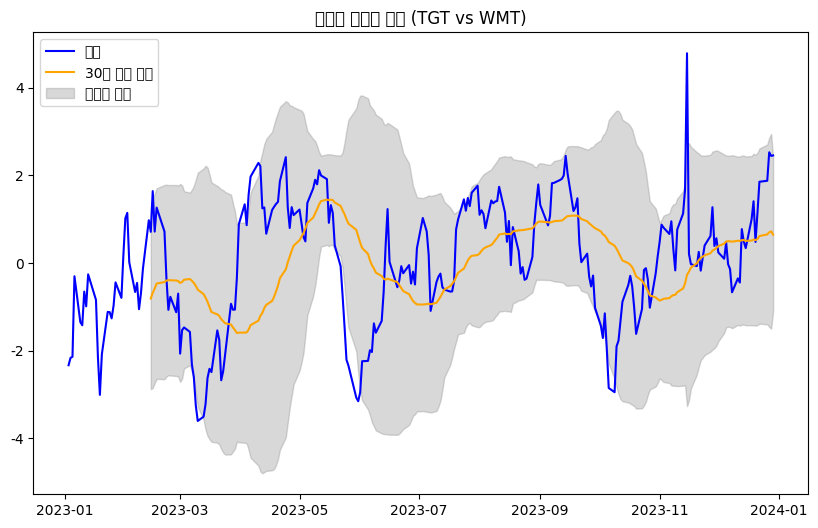

Bollinger Band graph saved for TGT and WMT at ./bollinger_band\TGT_WMT_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

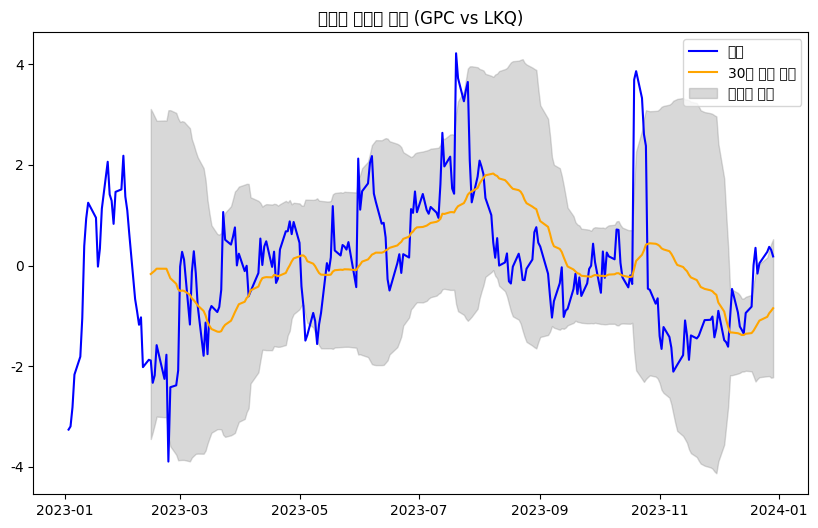

Bollinger Band graph saved for GPC and LKQ at ./bollinger_band\GPC_LKQ_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

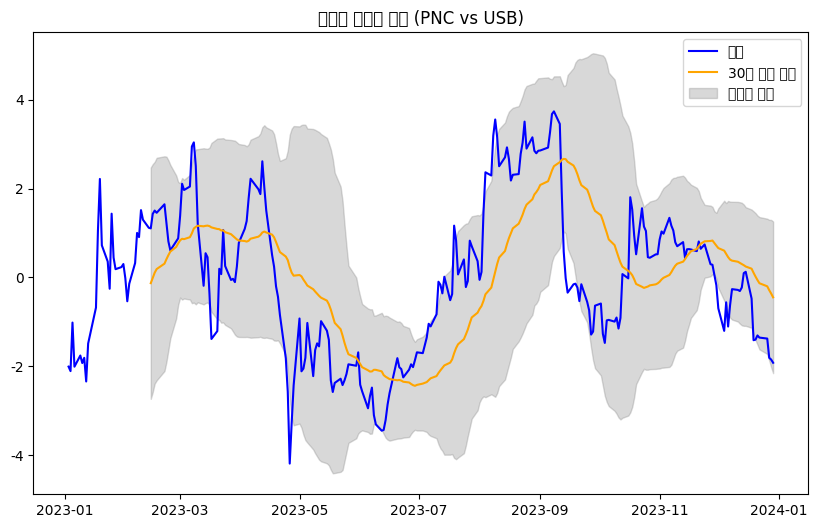

Bollinger Band graph saved for PNC and USB at ./bollinger_band\PNC_USB_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

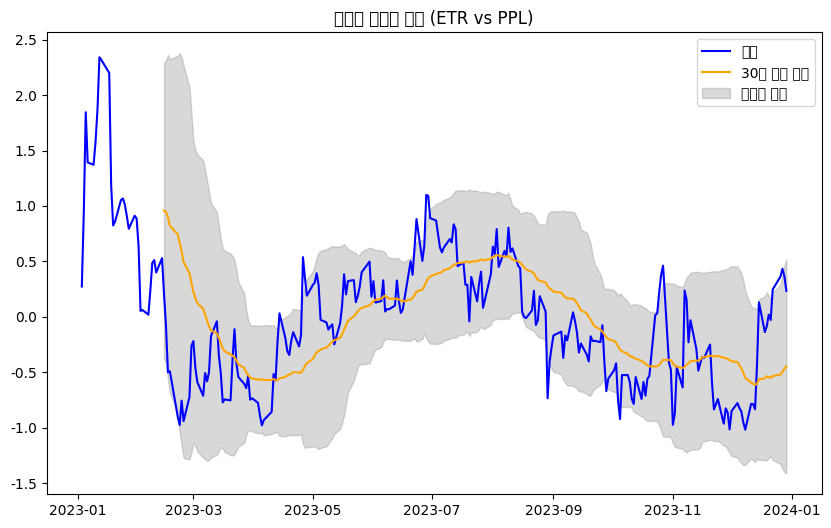

Bollinger Band graph saved for ETR and PPL at ./bollinger_band\ETR_PPL_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

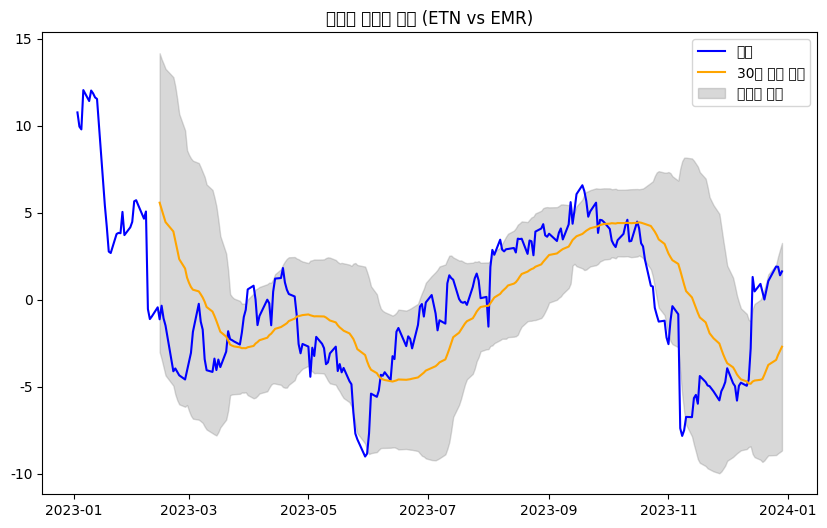

Bollinger Band graph saved for ETN and EMR at ./bollinger_band\ETN_EMR_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

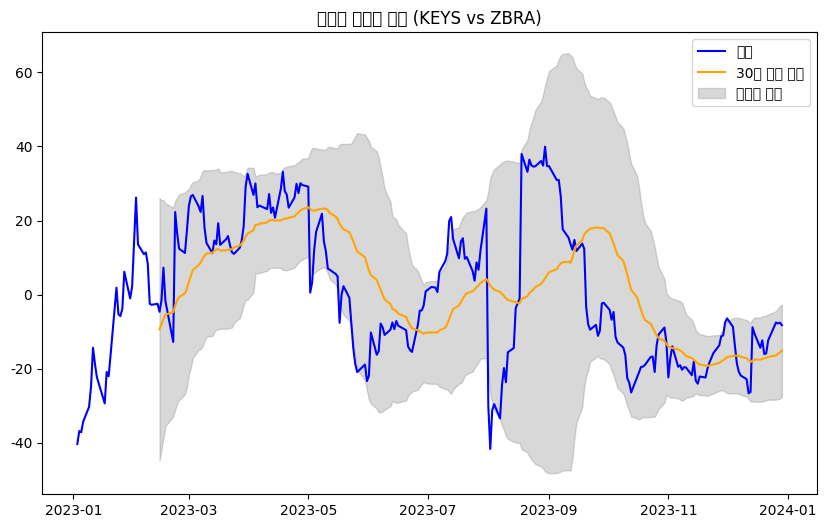

Bollinger Band graph saved for KEYS and ZBRA at ./bollinger_band\KEYS_ZBRA_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

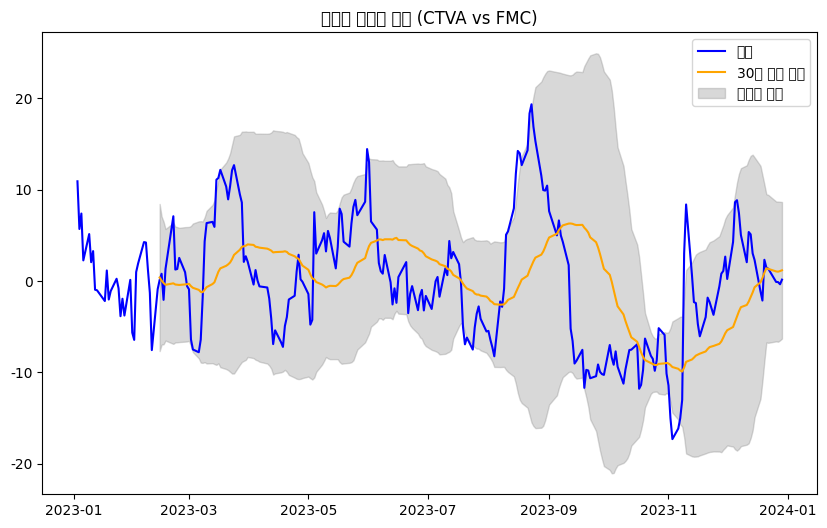

Bollinger Band graph saved for CTVA and FMC at ./bollinger_band\CTVA_FMC_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

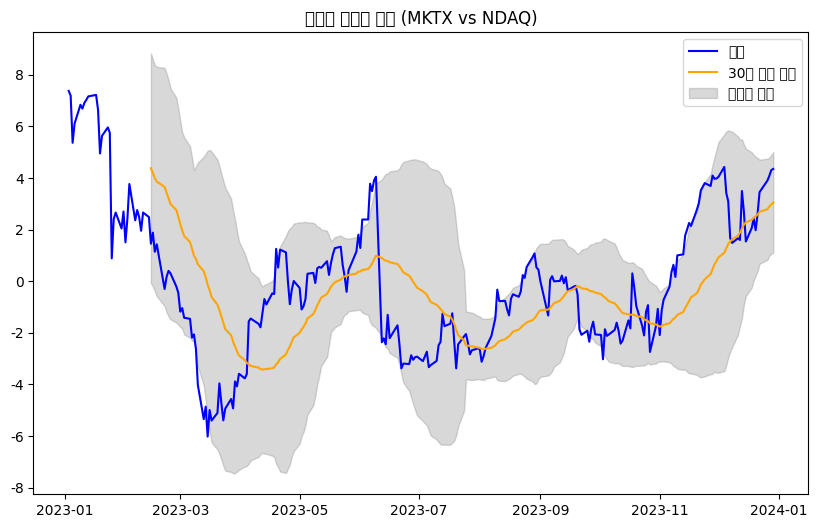

Bollinger Band graph saved for MKTX and NDAQ at ./bollinger_band\MKTX_NDAQ_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

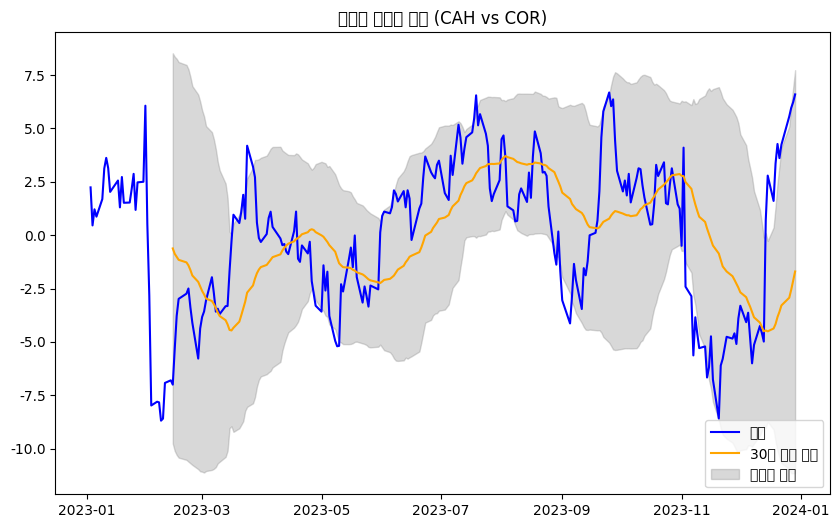

Bollinger Band graph saved for CAH and COR at ./bollinger_band\CAH_COR_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

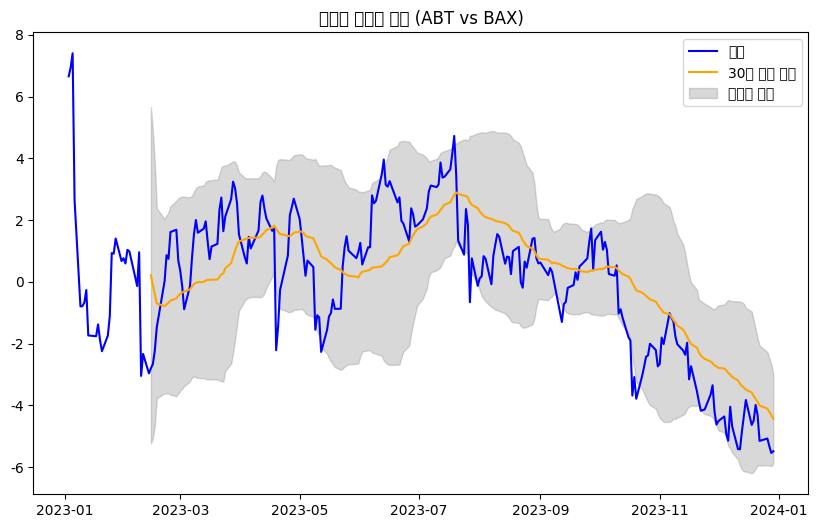

Bollinger Band graph saved for ABT and BAX at ./bollinger_band\ABT_BAX_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

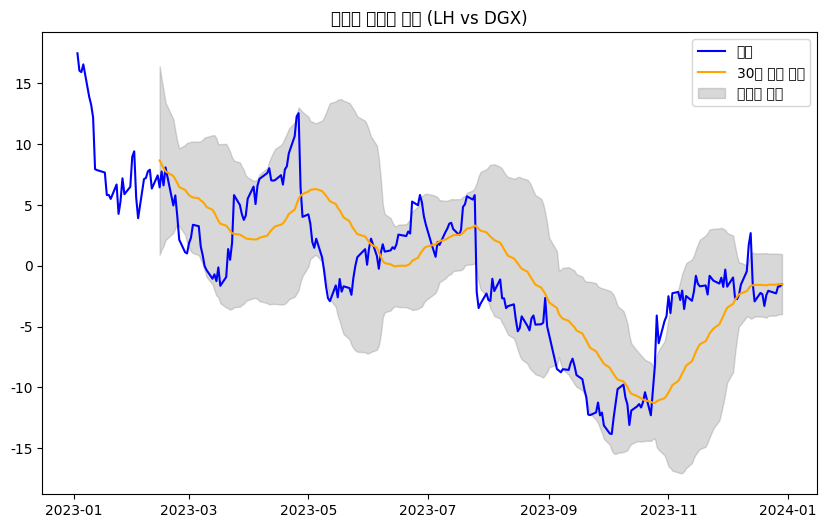

Bollinger Band graph saved for LH and DGX at ./bollinger_band\LH_DGX_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

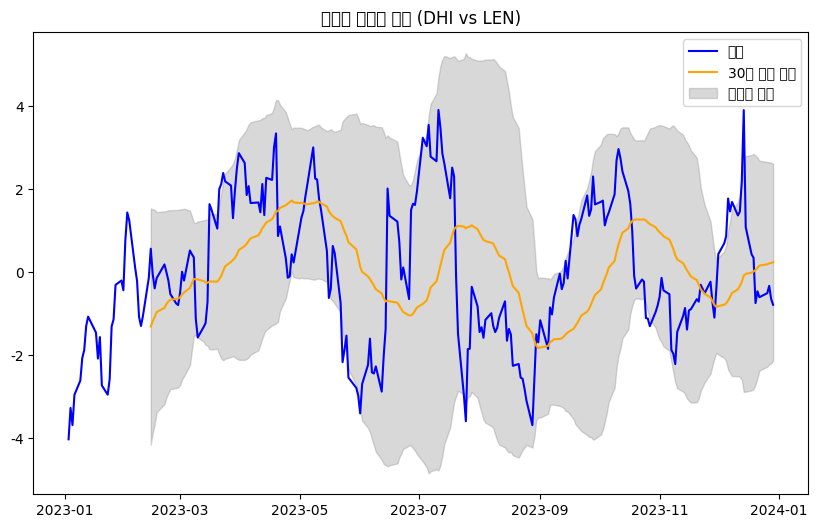

[                       0%                       ]

Bollinger Band graph saved for DHI and LEN at ./bollinger_band\DHI_LEN_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

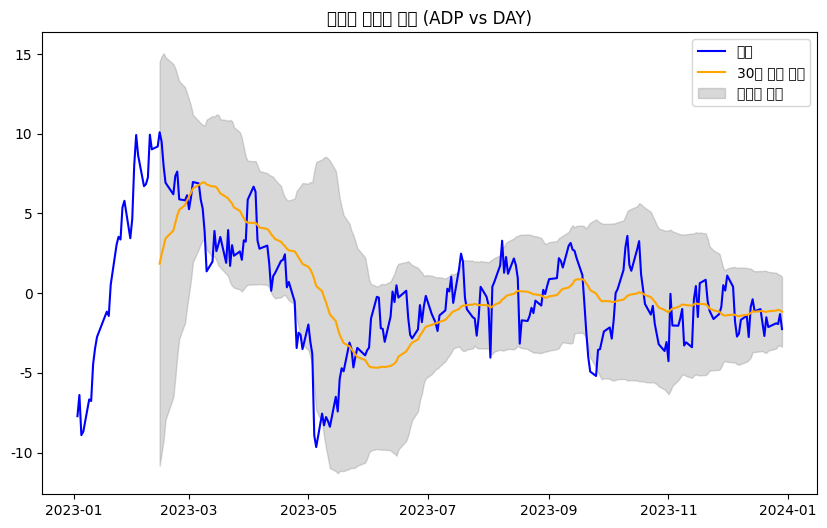

Bollinger Band graph saved for ADP and DAY at ./bollinger_band\ADP_DAY_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

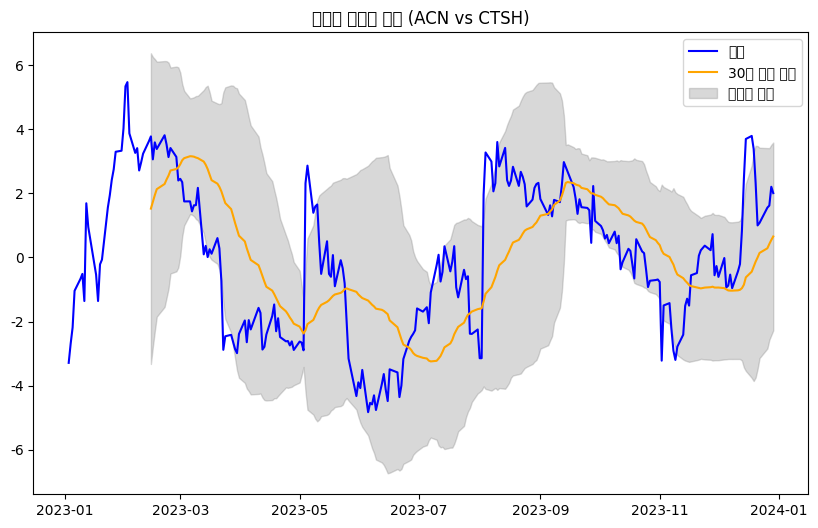

Bollinger Band graph saved for ACN and CTSH at ./bollinger_band\ACN_CTSH_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

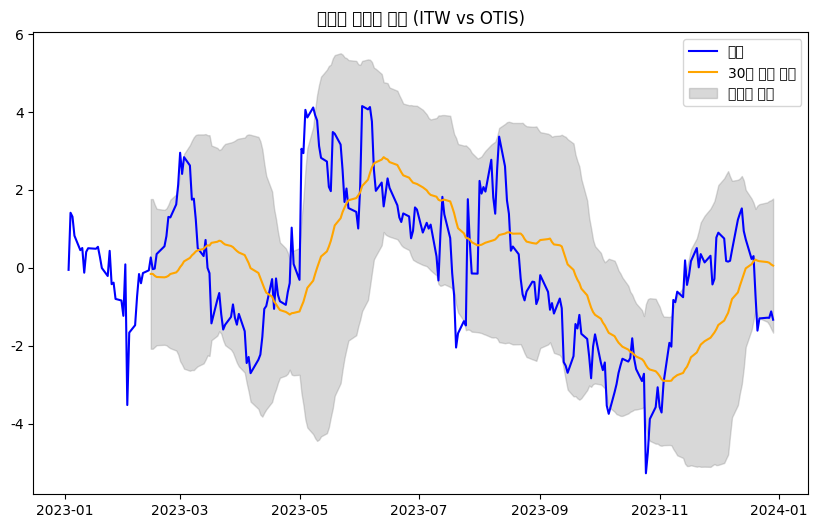

Bollinger Band graph saved for ITW and OTIS at ./bollinger_band\ITW_OTIS_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

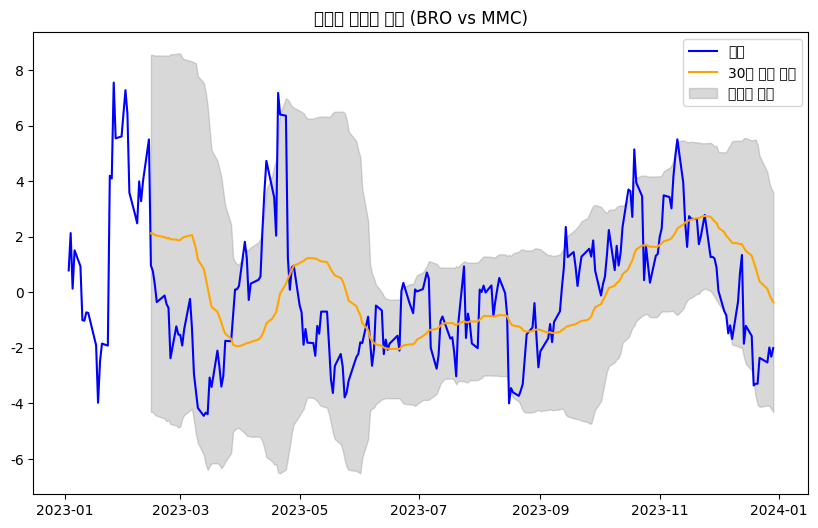

Bollinger Band graph saved for BRO and MMC at ./bollinger_band\BRO_MMC_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

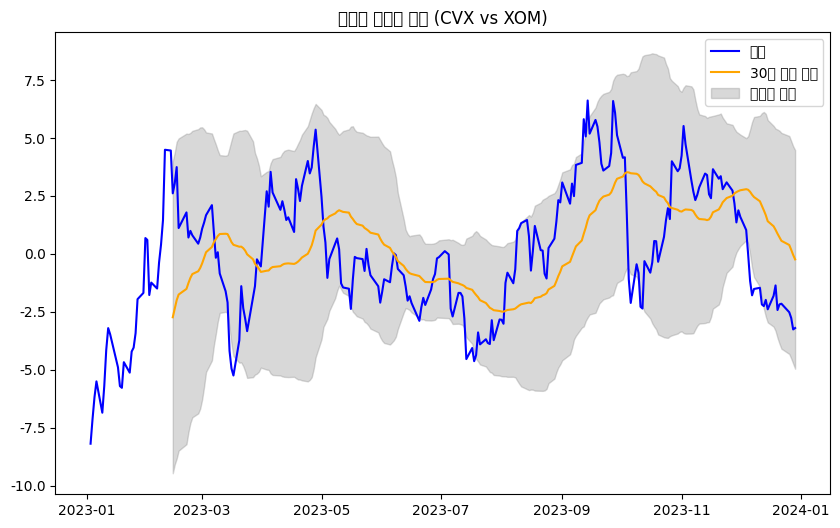

Bollinger Band graph saved for CVX and XOM at ./bollinger_band\CVX_XOM_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

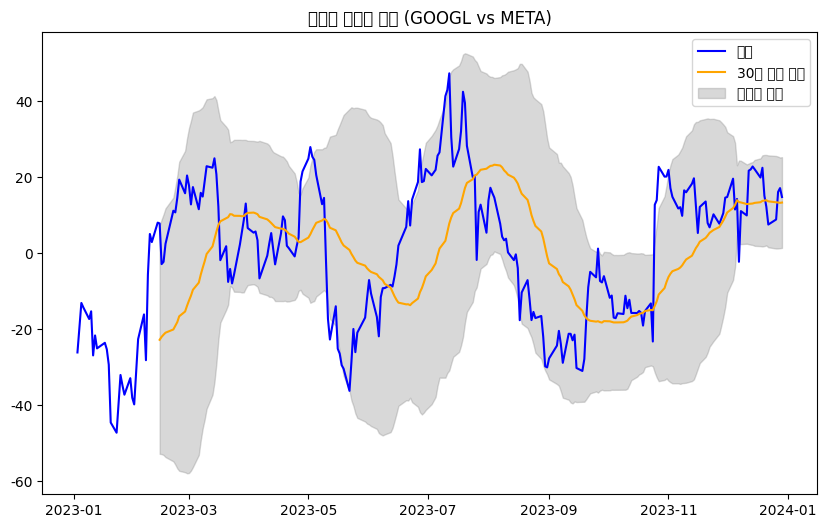

Bollinger Band graph saved for GOOGL and META at ./bollinger_band\GOOGL_META_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

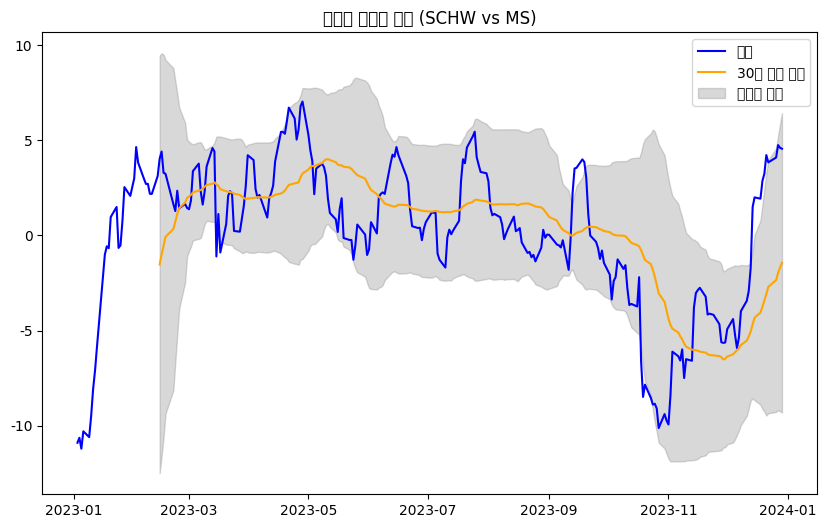

Bollinger Band graph saved for SCHW and MS at ./bollinger_band\SCHW_MS_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

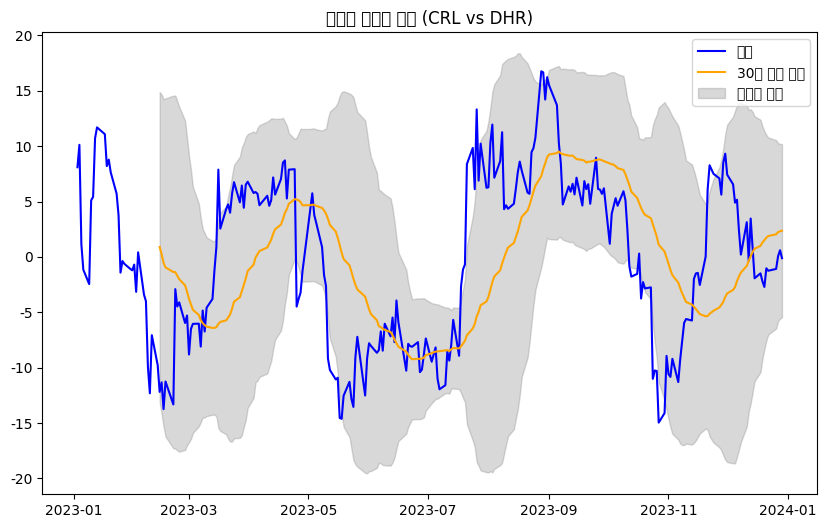

Bollinger Band graph saved for CRL and DHR at ./bollinger_band\CRL_DHR_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

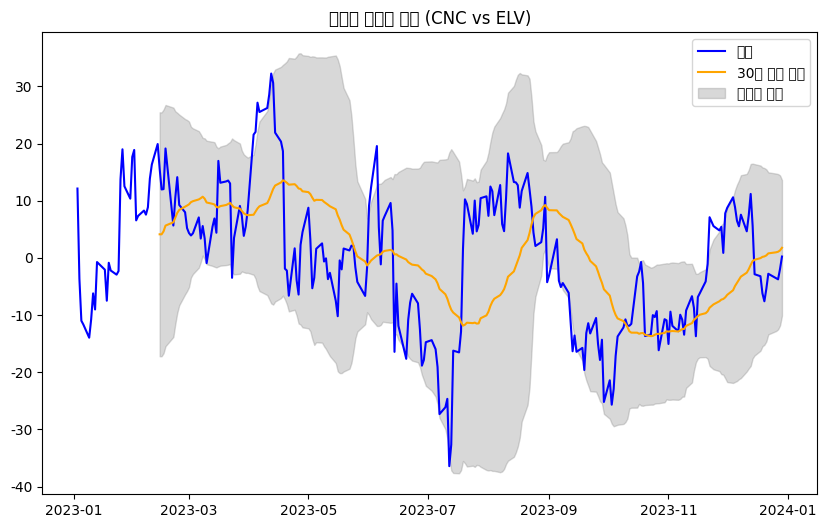

Bollinger Band graph saved for CNC and ELV at ./bollinger_band\CNC_ELV_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

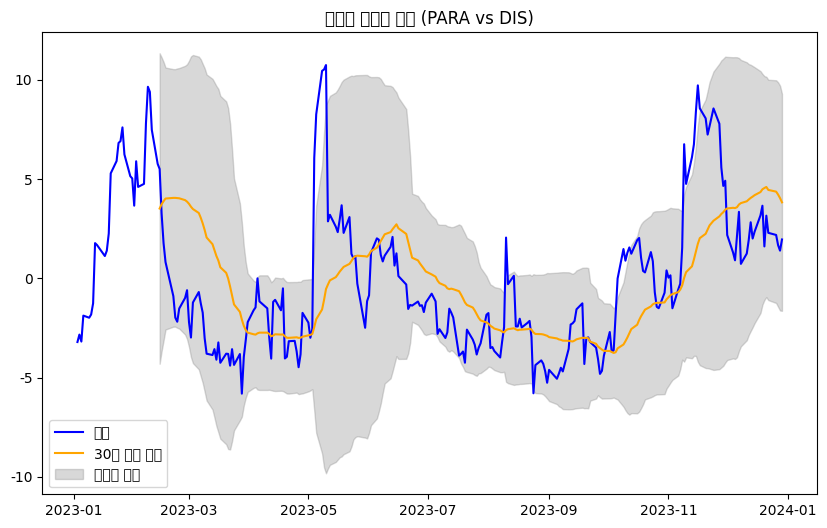

Bollinger Band graph saved for PARA and DIS at ./bollinger_band\PARA_DIS_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

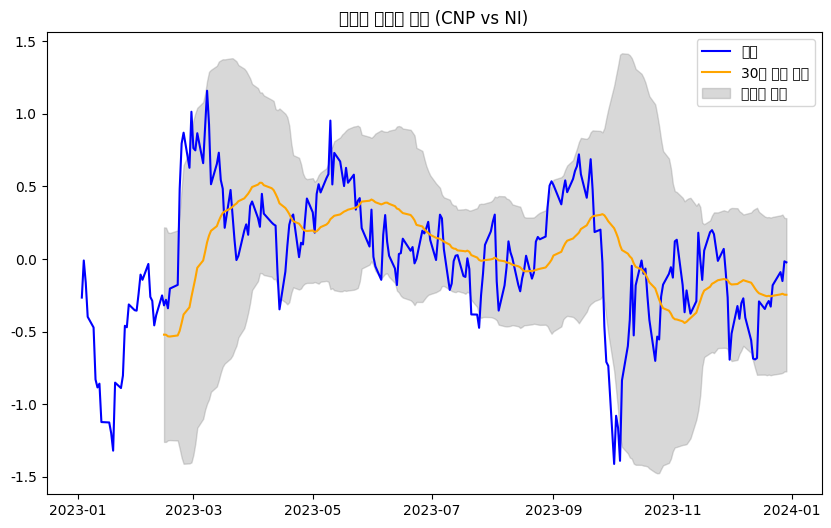

Bollinger Band graph saved for CNP and NI at ./bollinger_band\CNP_NI_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

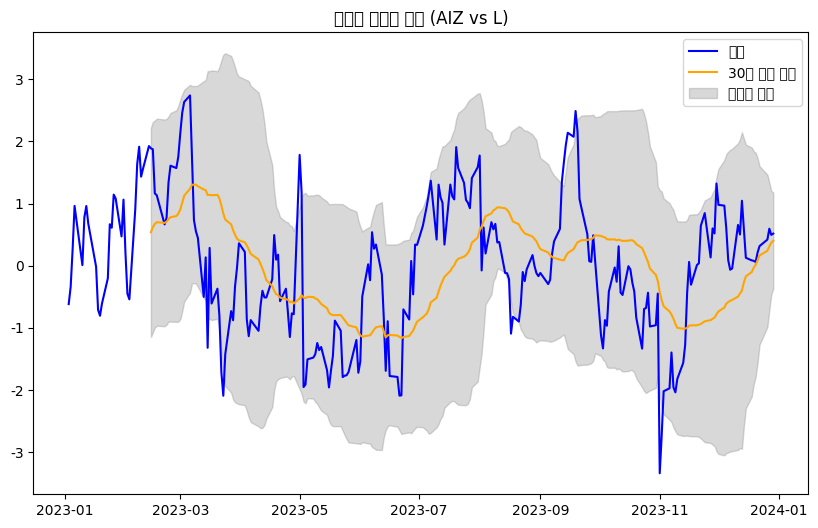

Bollinger Band graph saved for AIZ and L at ./bollinger_band\AIZ_L_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

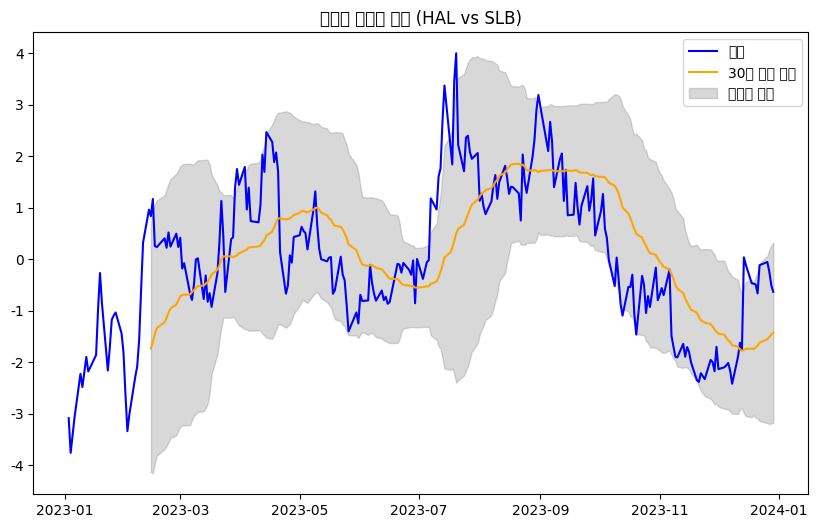

Bollinger Band graph saved for HAL and SLB at ./bollinger_band\HAL_SLB_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

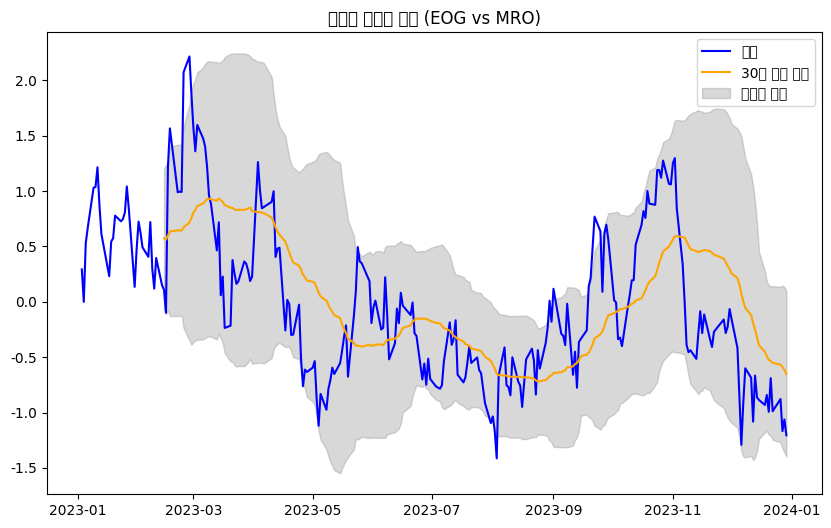

Bollinger Band graph saved for EOG and MRO at ./bollinger_band\EOG_MRO_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

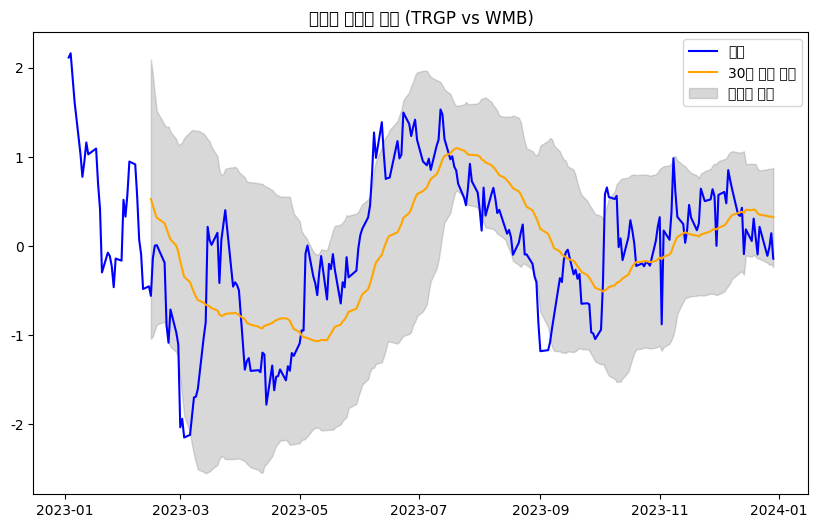

Bollinger Band graph saved for TRGP and WMB at ./bollinger_band\TRGP_WMB_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

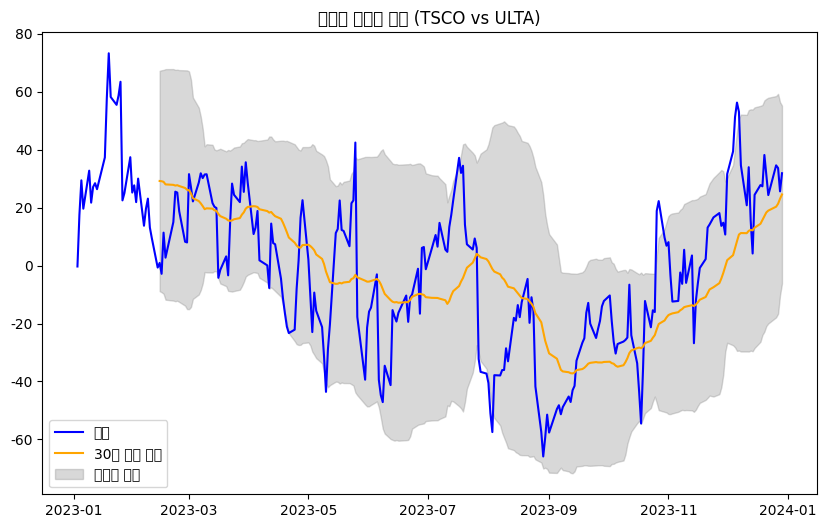

Bollinger Band graph saved for TSCO and ULTA at ./bollinger_band\TSCO_ULTA_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

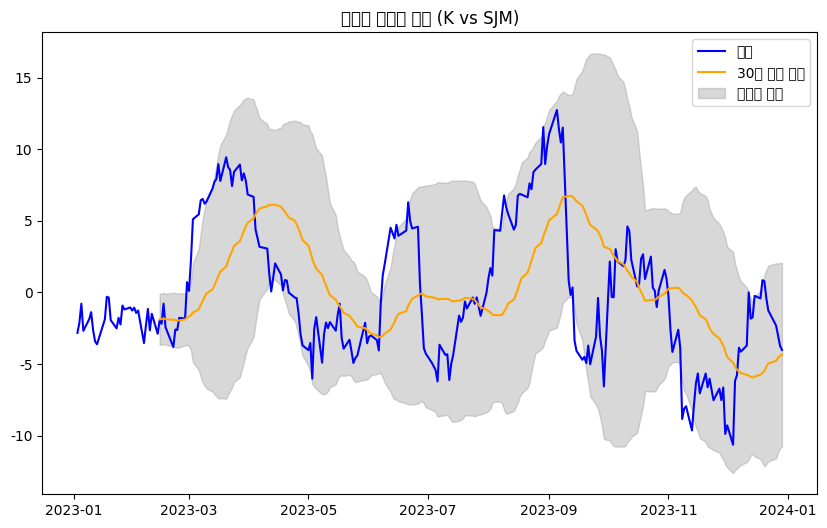

Bollinger Band graph saved for K and SJM at ./bollinger_band\K_SJM_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

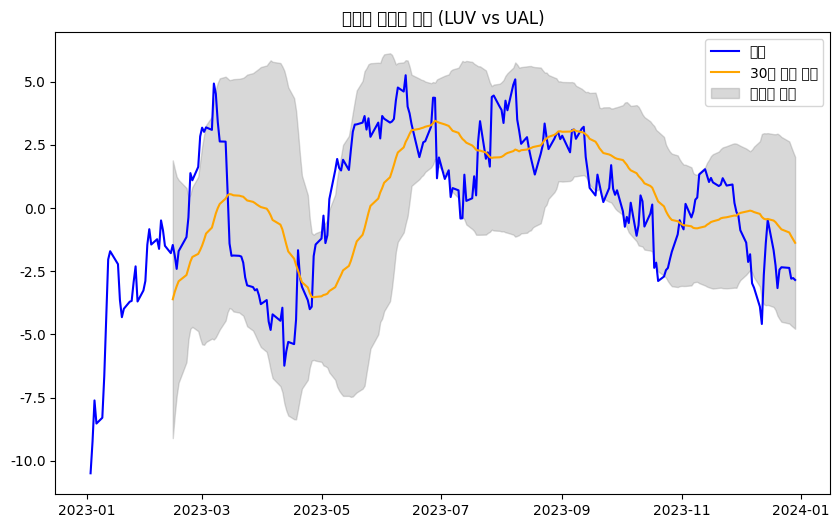

Bollinger Band graph saved for LUV and UAL at ./bollinger_band\LUV_UAL_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

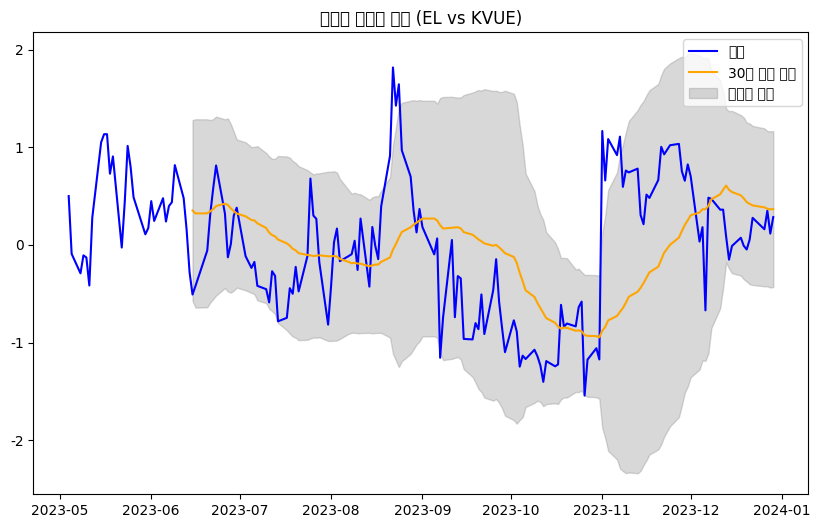

Bollinger Band graph saved for EL and KVUE at ./bollinger_band\EL_KVUE_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

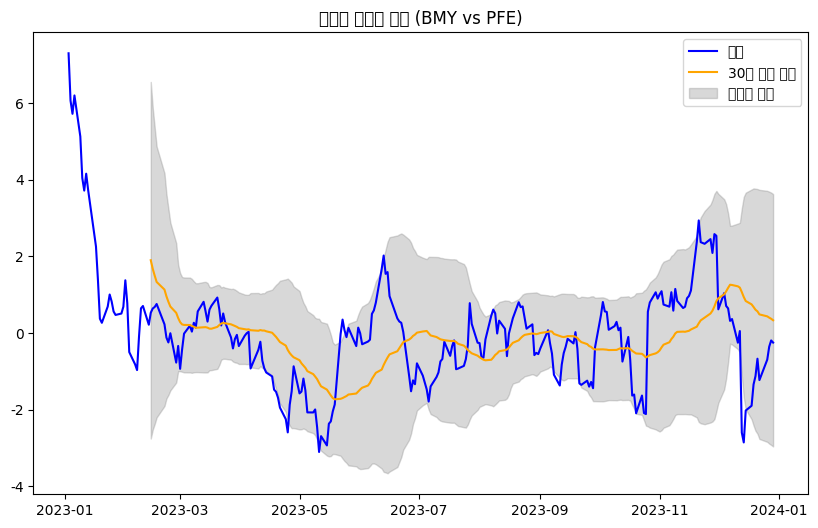

Bollinger Band graph saved for BMY and PFE at ./bollinger_band\BMY_PFE_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

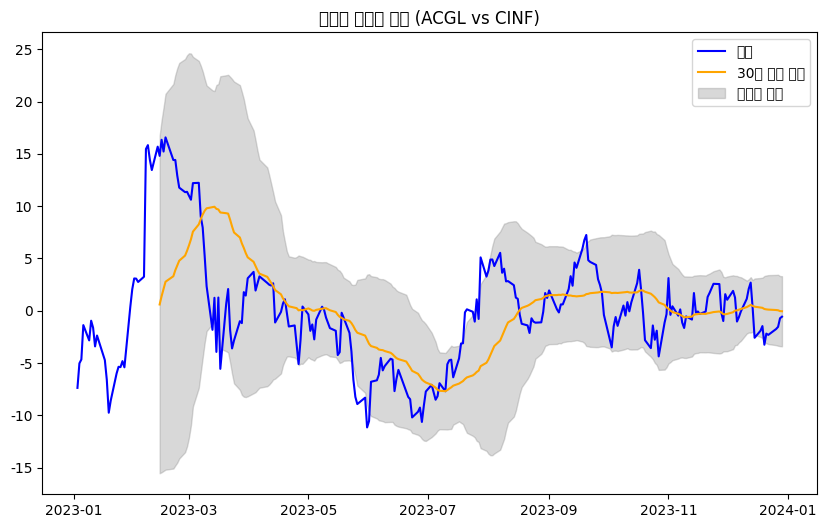

Bollinger Band graph saved for ACGL and CINF at ./bollinger_band\ACGL_CINF_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

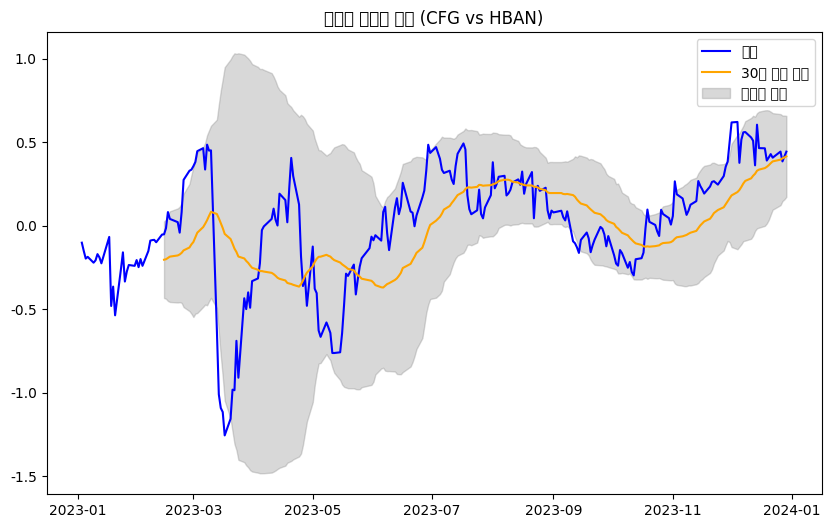

Bollinger Band graph saved for CFG and HBAN at ./bollinger_band\CFG_HBAN_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

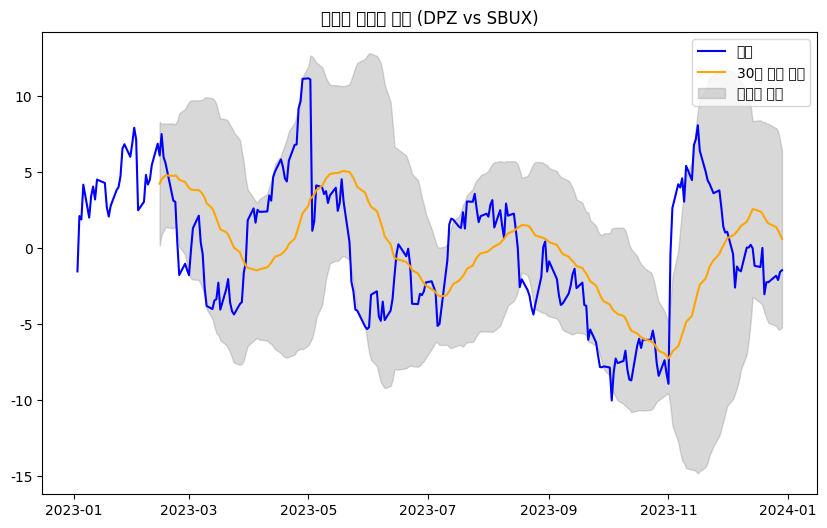

Bollinger Band graph saved for DPZ and SBUX at ./bollinger_band\DPZ_SBUX_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

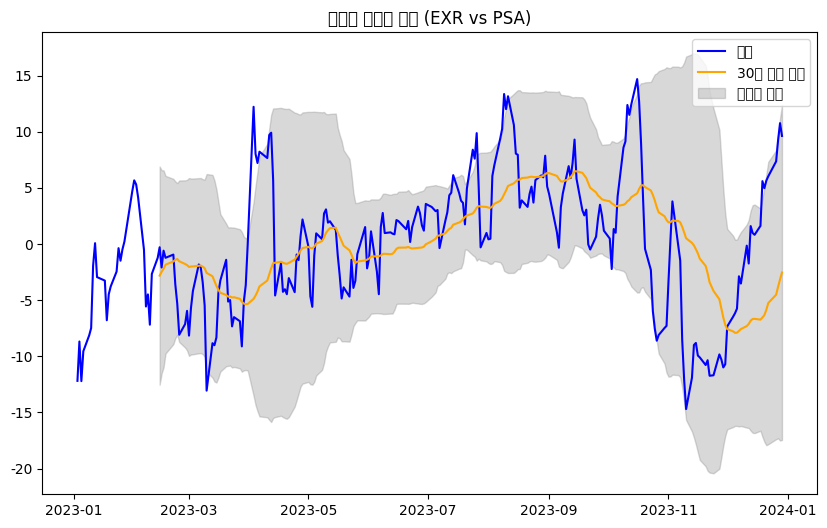

Bollinger Band graph saved for EXR and PSA at ./bollinger_band\EXR_PSA_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

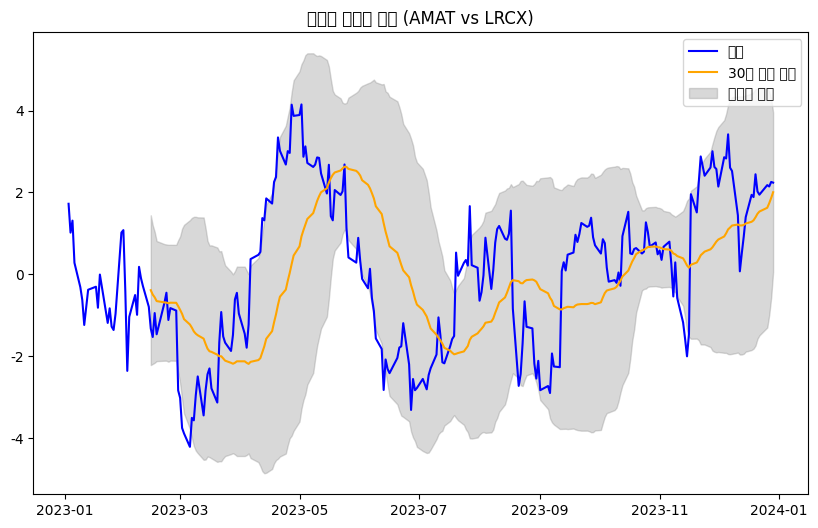

Bollinger Band graph saved for AMAT and LRCX at ./bollinger_band\AMAT_LRCX_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

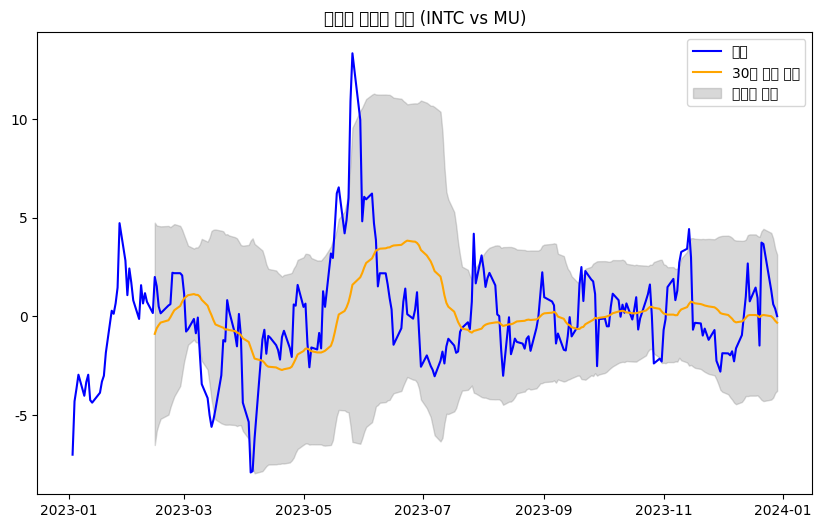

Bollinger Band graph saved for INTC and MU at ./bollinger_band\INTC_MU_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

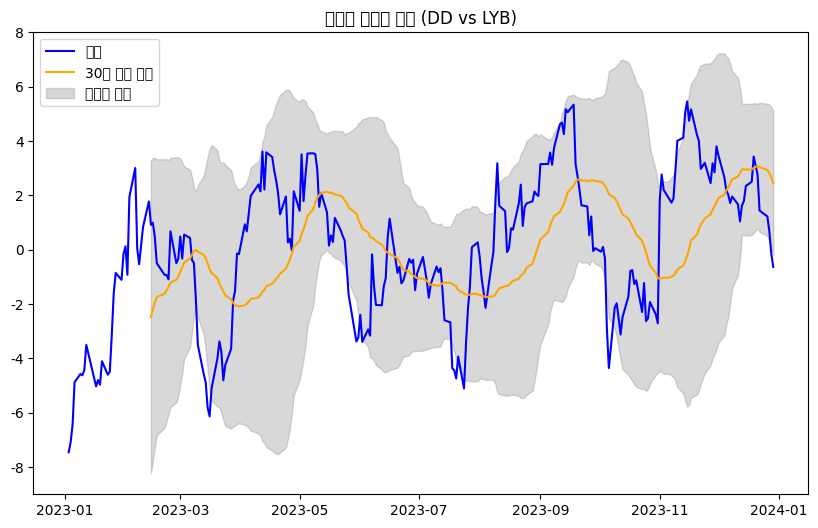

Bollinger Band graph saved for DD and LYB at ./bollinger_band\DD_LYB_bollinger.png


[*********************100%***********************]  2 of 2 completed
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eujin\AppData\Local\Packages\PythonSoftwareFoundati

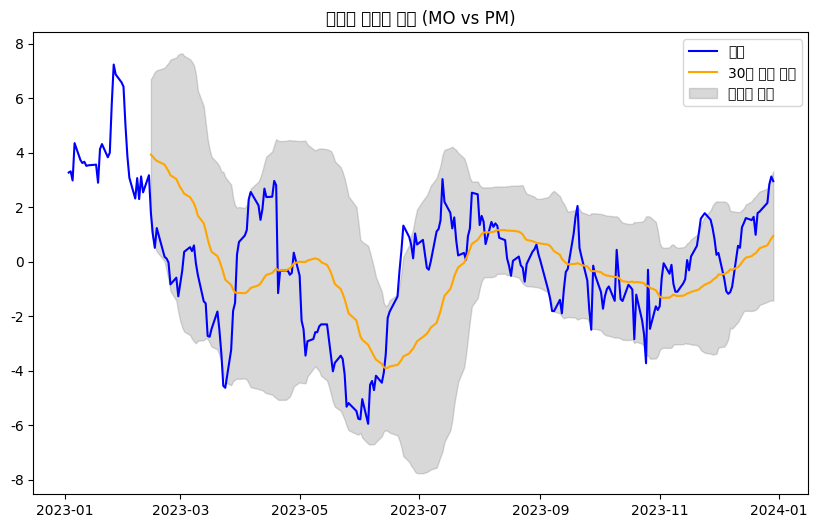

Bollinger Band graph saved for MO and PM at ./bollinger_band\MO_PM_bollinger.png


In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 폰트 설정
rcParams['font.family'] = 'DejaVu Sans'  # 기본 폰트 설정
rcParams['axes.unicode_minus'] = False  # 음수 기호 표시 문제 해결

# 산업군별 안정적인 페어에 대한 볼린저 밴드 그래프 출력 함수
def all_bollinger_bands(data_func, stable_pairs_df, start_date, end_date, output_folder="./bollinger_band"):
    # 출력 폴더 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for _, row in stable_pairs_df.iterrows():
        try:
            data = data_func([row['Ticker 1'], row['Ticker 2']], start_date=start_date, end_date=end_date)
            _, residuals = calculate_p_value(data, row['Ticker 1'], row['Ticker 2'])
            if residuals is not None:
                # 그래프 생성 및 저장
                file_name = f"{row['Ticker 1']}_{row['Ticker 2']}_bollinger.png"
                file_path = os.path.join(output_folder, file_name)
                
                # 볼린저 밴드 그래프 생성
                plot_bollinger_bands(residuals, row['Ticker 1'], row['Ticker 2'])
                
                # 그래프 저장
                plt.savefig(file_path, bbox_inches='tight')  # 여백 문제 방지를 위해 bbox_inches 사용
                plt.close()  # 메모리 관리를 위해 그래프 닫기
                
                print(f"Bollinger Band graph saved for {row['Ticker 1']} and {row['Ticker 2']} at {file_path}")
            else:
                print(f"No residuals data available for {row['Ticker 1']} and {row['Ticker 2']}. Skipping.")
        except Exception as e:
            print(f"Error processing {row['Ticker 1']} and {row['Ticker 2']}: {e}")


# 안정적인 페어에 대해 볼린저 밴드 그래프 출력
all_bollinger_bands(get_data, stable_pairs_df, start_date="2023-01-01", end_date="2023-12-31")

## 동적 선택을 통한 페어 분석 함수

In [10]:

'''
def analyze_by_selection(selection_type, selection_name, start_date, end_date):
    if selection_type == "sector":
        # 선택한 섹터로 분석
        tickers = top_by_sector.loc[selection_name]['Symbol'].tolist()
        data_func = get_data
    elif selection_type == "industry":
        # 선택한 산업군으로 분석
        tickers = all_per_industry.loc[selection_name]['Symbol'].tolist()  # 산업군 선택
        data_func = get_data
    else:
        print("올바르지 않은 선택입니다. 섹터 또는 산업군을 입력하세요.")
        return

    # 페어 분석 수행
    select_stable_pair(data_func, tickers, start_date, end_date)


#사용자 선택 기반 페어 분석 실행
selection_type = input("분석하려는 선택을 입력하세요 (sector or industry): ")
selection_name = input("분석할 섹터 또는 산업군의 이름을 입력하세요: ")
analyze_by_selection(selection_type, selection_name, start_date="2020-01-01", end_date="2023-01-01")
'''

'\ndef analyze_by_selection(selection_type, selection_name, start_date, end_date):\n    if selection_type == "sector":\n        # 선택한 섹터로 분석\n        tickers = top_by_sector.loc[selection_name][\'Symbol\'].tolist()\n        data_func = get_data\n    elif selection_type == "industry":\n        # 선택한 산업군으로 분석\n        tickers = all_per_industry.loc[selection_name][\'Symbol\'].tolist()  # 산업군 선택\n        data_func = get_data\n    else:\n        print("올바르지 않은 선택입니다. 섹터 또는 산업군을 입력하세요.")\n        return\n\n    # 페어 분석 수행\n    select_stable_pair(data_func, tickers, start_date, end_date)\n\n\n#사용자 선택 기반 페어 분석 실행\nselection_type = input("분석하려는 선택을 입력하세요 (sector or industry): ")\nselection_name = input("분석할 섹터 또는 산업군의 이름을 입력하세요: ")\nanalyze_by_selection(selection_type, selection_name, start_date="2020-01-01", end_date="2023-01-01")\n'

## 데이터 모니터링

In [11]:
'''
# 산업군별 안정적 페어를 저장하는 딕셔너리
stable_pairs = {}

# p-value를 계산하는 함수
def check_p_value(data_func, ticker1, ticker2, start_date, end_date):
    data = data_func([ticker1, ticker2], start_date=start_date, end_date=end_date)
    p_value, _ = calculate_p_value(data, ticker1, ticker2)
    return p_value

# 산업군별로 초기 안정적 페어 찾기
def initialize_stable_pairs(industry_tickers, data_func, start_date, end_date):
    stable_pair = select_stable_pair(data_func, industry_tickers, start_date, end_date)
    if stable_pair:
        stable_pairs[stable_pair] = check_p_value(data_func, stable_pair[0], stable_pair[1], start_date, end_date)

# 주기적으로 안정적 페어를 모니터링하는 함수
def monitor_stable_pairs(data_func, start_date, end_date, adf_threshold=0.05, interval=3600):
    while True:
        print("Monitoring stable pairs...")
        for pair in list(stable_pairs.keys()):
            ticker1, ticker2 = pair
            p_value = check_p_value(data_func, ticker1, ticker2, start_date, end_date)

            if p_value is None:
                print(f"Data for pair {ticker1} and {ticker2} is missing. Skipping...")
                continue

            print(f"Current p-value for {ticker1} and {ticker2}: {p_value}")
            if p_value > adf_threshold:
                print(f"p-value for {pair} exceeded threshold. Re-evaluating pairs for this industry...")
                
                # 산업군 내 새로운 페어 찾기
                industry_tickers = all_per_industry.loc[industry].Symbol.tolist()  # 예시: 해당 산업군에 대한 티커 리스트
                new_stable_pair = select_stable_pair(data_func, industry_tickers, start_date, end_date)
                
                if new_stable_pair:
                    stable_pairs[new_stable_pair] = check_p_value(data_func, new_stable_pair[0], new_stable_pair[1], start_date, end_date)
                    print(f"Updated stable pair for {industry}: {new_stable_pair} with p-value {stable_pairs[new_stable_pair]}")
                
                # 기존 페어 제거
                del stable_pairs[pair]

        # 일정 시간 대기 후 다시 체크
        time.sleep(interval)

# 예시 실행 코드
industry_name = "your_industry_name"
industry_tickers = all_per_industry.loc[industry_name]['Symbol'].tolist()
data_func = get_data

# 초기 페어를 찾고 안정적인 페어를 모니터링
initialize_stable_pairs(industry_tickers, data_func, start_date="2020-01-01", end_date="2023-01-01")
monitor_stable_pairs(data_func, start_date="2020-01-01", end_date="2023-01-01")
'''

'\n# 산업군별 안정적 페어를 저장하는 딕셔너리\nstable_pairs = {}\n\n# p-value를 계산하는 함수\ndef check_p_value(data_func, ticker1, ticker2, start_date, end_date):\n    data = data_func([ticker1, ticker2], start_date=start_date, end_date=end_date)\n    p_value, _ = calculate_p_value(data, ticker1, ticker2)\n    return p_value\n\n# 산업군별로 초기 안정적 페어 찾기\ndef initialize_stable_pairs(industry_tickers, data_func, start_date, end_date):\n    stable_pair = select_stable_pair(data_func, industry_tickers, start_date, end_date)\n    if stable_pair:\n        stable_pairs[stable_pair] = check_p_value(data_func, stable_pair[0], stable_pair[1], start_date, end_date)\n\n# 주기적으로 안정적 페어를 모니터링하는 함수\ndef monitor_stable_pairs(data_func, start_date, end_date, adf_threshold=0.05, interval=3600):\n    while True:\n        print("Monitoring stable pairs...")\n        for pair in list(stable_pairs.keys()):\n            ticker1, ticker2 = pair\n            p_value = check_p_value(data_func, ticker1, ticker2, start_date, end_date)\n\n   

# 백테스트

## 데이터 준비

In [19]:
# 테이블에서 종목 리스트 가져오기
tickers_list = list(set(stable_pairs_df["Ticker 1"].tolist() + stable_pairs_df["Ticker 2"].tolist()))

# 데이터 다운로드 및 저장
for ticker in tickers_list:
    data = yf.download(ticker, start="2024-01-01", end="2024-06-30")
    data.to_csv(f"./backtest_csv/{ticker}_backtest.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 백테스트 전략 구현

In [ ]:

# 폰트 및 그래프 설정
matplotlib.use('Agg')  # 백엔드 설정 (그래프 저장만 수행)
plt.rcParams["figure.figsize"] = [12, 8]  # 그래프 크기 조정
plt.rcParams["font.size"] = 10  # 폰트 크기
plt.rcParams["lines.linewidth"] = 1.5  # 선 두께
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 지원


class PairTradingStrategy(bt.Strategy):
    params = (
        ('lookback_period', 30),  # 이동 평균 및 표준편차 계산 기간
        ('zscore_threshold', 2),  # 매매 임계값 (z-score 기준)
    )

    def __init__(self):
        # 데이터 피드 설정 (두 종목만 사용)
        self.data0 = self.datas[0]
        self.data1 = self.datas[1]
        
        # 스프레드 계산
        self.spread = self.data0.close - self.data1.close

        # 이동 평균 및 표준편차 계산
        self.moving_avg = bt.indicators.SimpleMovingAverage(self.spread, period=self.params.lookback_period)
        self.moving_std = bt.indicators.StandardDeviation(self.spread, period=self.params.lookback_period)

        # 볼린저 밴드 계산
        self.upper_band = self.moving_avg + self.params.zscore_threshold * self.moving_std
        self.lower_band = self.moving_avg - self.params.zscore_threshold * self.moving_std

        self.trades = []

    def next(self):
        # 현재 스프레드 값
        current_spread = self.spread[0]

        # 포지션이 없는 경우
        if not self.position:
            if current_spread > self.upper_band[0]:
                # 상단 밴드를 초과하면 매도-매수
                self.sell(data=self.data0, size=10)  # 첫 번째 종목 매도
                self.buy(data=self.data1, size=10)  # 두 번째 종목 매수
                self.trades.append({'Action': 'Sell-Buy', 'Date': self.data0.datetime.date(0)})
            elif current_spread < self.lower_band[0]:
                # 하단 밴드를 초과하면 매수-매도
                self.buy(data=self.data0, size=10)  # 첫 번째 종목 매수
                self.sell(data=self.data1, size=10)  # 두 번째 종목 매도
                self.trades.append({'Action': 'Buy-Sell', 'Date': self.data0.datetime.date(0)})

        # 포지션이 있는 경우
        else:
            if self.upper_band[0] > current_spread > self.lower_band[0]:
                # 스프레드가 이동 평균으로 돌아오면 포지션 청산
                self.close(data=self.data0)
                self.close(data=self.data1)
                self.trades.append({'Action': 'Close', 'Date': self.data0.datetime.date(0)})






# Backtrader 설정 in data.to_csv(f"./backtest_csv/{ticker}_backtest.csv")

def run_backtest(pair):
    ticker1, ticker2 = pair["Ticker 1"], pair["Ticker 2"]
    data0 = bt.feeds.GenericCSVData(dataname=f"./backtest_csv/{ticker}_backtest.csv", dtformat="%Y-%m-%d", openinterest=-1, name=ticker1)
    data1 = bt.feeds.GenericCSVData(dataname=f"./backtest_csv/{ticker}_backtest.csv", dtformat="%Y-%m-%d", openinterest=-1, name=ticker2)

    cerebro = bt.Cerebro()
    cerebro.adddata(data0)
    cerebro.adddata(data1)
    cerebro.addstrategy(PairTradingStrategy)
    cerebro.addobserver(bt.observers.BuySell) # 매수/매도 표시
    cerebro.addobserver(bt.observers.Value)  # 포트폴리오 가치

    strategy = cerebro.run()
    strategy_instance = strategy[0]

    trades_df = pd.DataFrame(strategy_instance.trades)
    trades_df.to_csv(f"./trades_csv/{ticker1}-{ticker2}_trades.csv", index=False)

    fig = cerebro.plot(iplot=False, style='candle')[0][0]
    fig.savefig(f"./result/{ticker1}-{ticker2}_result.png", dpi=150, bbox_inches='tight')
    return f"{ticker1}-{ticker2} 백테스트 완료"

# 병렬 처리로 모든 페어에 대해 백테스트 실행
if __name__ == "__main__":
    with Pool(processes=4) as pool:
        results = pool.map(run_backtest, stable_pairs_df.to_dict('records'))
        for result in results:
            print(result)




# TODO 그래프 분리?-그래프 width값 변경?
# TODO 페어별 매수,매도, 수익률 테이블출력 및 csv파일로 저장  


## 예시문제-유튜브

In [ ]:
!pip install backtesting
!pip install ta #기술지표 계산 처리하는 라이브러리
!pip install yfinance #금융상품 가격 데이터 가져오는 라이브러리

import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

#전략 정의하는 클래스
class SMAcross(Strategy):

    n1=50#단기기간
    n2=100#장기기간

    def init(self):
        close =  self.data.Close
        self.sma1 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n1)
        self.sma2 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.but()
        elif crossover(self.sma2,self.sma1):
            self.sell()
 
df = yf.download('BTC-USD',start='2018-01-01')

bt = Backtest(df, SMAcross, cash=100000, commission=0.002, exclusive_orders=True)

#최적화
optim = bt.optimize(n1 = range(50,160,10),
                    n2 = range(50,160,10),
                    constraint = lambda x: x.n2-x.n1 > 20,
                    maximize = 'Return [%]')

bt.plot()









^C
Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\eujin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#기술지표': Expected package name at the start of dependency specifier
    #기술지표
    ^



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\eujin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#금융상품': Expected package name at the start of dependency specifier
    #금융상품
    ^


ModuleNotFoundError: No module named 'ta'

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ------------- -------------------------- 2.4/6.9 MB 12.2 MB/s eta 0:00:01
   ----------------------------- ---------- 5.0/6.9 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 6.9/6.9 MB 11.7 MB/s eta 0:00:00
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173962 sha256=8a29dcebfcae4703d0e3dc452609a7e35302a884719d75f58cb50d23bc3cfa1d
  Stored in directory: c:


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\eujin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
